# 2D Single scatterer 
- [Theory](#Theory)
    - [Green's functions](#Green's-functions)
    - [Born approximation and cross section](#Cross-section)
- [Application](#Application)
    - [Potential and form factor](#Potential-and-form-factor)
    - [Linear array](#Linear-array)
    

In [2]:
import importlib as imp
from scipy.special import jn,kn,hankel1
from utils import*                  ;imp.reload(dsp)
import multislice.multi_2D as ms    ;imp.reload(ms)
import wallpp.plane_group as pg     ;imp.reload(pg)
#plt.close('all')
figsize=(10,5)
kwargs=dict(figsize=(10,5))
path='figures/single_'
opts='TMv'#MK'
opt = 'p'

## Theory 

### Green's functions
Schrodinger's equation in free space is : 
\begin{eqnarray}
    \left\{\nabla^2 + k^2 \right\}\Psi(r,\theta) &=& 0\\
    \left\{z\frac{d}{dz}\left(z\frac{d}{dz}\right) + (z^2 - n^2) \right\}R(z) &=& 0\\
    \left\{\frac{d^2}{d\theta^2} + n^2 \right\}\Phi(\theta) &=&
\end{eqnarray}
where we use $z=kr$. 

The solutions are the Bessel functions of the first $J_n$ and second kind $Y_n$. The Hankel functions of the first kind $H_n^{(1)}=J_n+iY_n$ are also solutions and the Green's functions are chosen for $n=0$ as $H_0^{(1)}$.


The asymptotic behaviour of $H_n^{(1)}$ is that of a [circular wave](http://lampx.tugraz.at/~hadley/physikm/script/waves/circular2d.en.php) : 
\begin{equation}
    H_0^{(1)}(kr) \underset{\infty}{\sim} \sqrt{\frac{2}{\pi kr}}e^{j(kr-\pi/4)}
\end{equation}
In particular $H_0^{(1)}$ converges to this expression faster than the higher order terms.

/home/tarik/Documents/git/mygit/utilities/utils/displayStandards.py:749: UserWarning: Matplotlib is currently using GTK3Agg, which is a non-GUI backend, so cannot show the figure.
  if 'p' in opt : ax.figure.show()


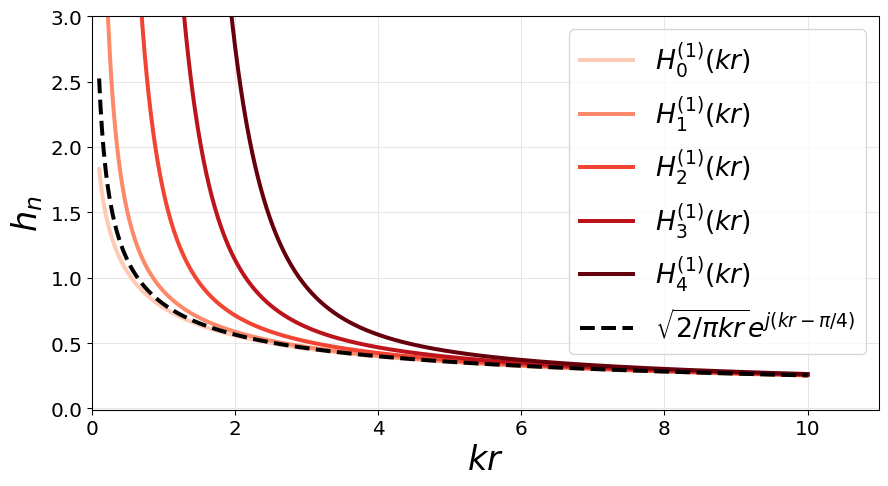

In [3]:
N=5
kr=np.linspace(0.1,10,1000)
fz=np.abs
# psi_c=np.sqrt(2/np.pi)*np.cos(kr-np.pi/4)/np.sqrt(kr)
# plts=[[kr,fz(np.sin(kr)/kr),'b','$sinc$']]

psi_c=np.sqrt(2/np.pi)*np.exp(1J*(kr-np.pi/4))/np.sqrt(kr)
hn=[hankel1(n,kr) for n in range(N)]

plts=[[kr,fz(hn[i]),c,'$H_%d^{(1)}(kr)$'%i] for i,c in zip(range(N),dsp.getCs('Reds',N))]
plts+=[[kr,fz(psi_c),'k--','$\sqrt{2/\pi kr}e^{j(kr-\pi/4)}$']]
dsp.stddisp(plts,labs=['$kr$','$h_n$'],lw=3,figsize=figsize,xylims=[0,11,-0.01,3]);


Note that the circular wave $\mathcal C(kr)$ is not a solution of the radial equation as it significantly departs from $H_0^{(1)}(kr)$ at small values of $kr$.
It becomes a good approximation in the far field but even then is not quite a solution as there remains a constant residual error when injected in the radial equation.

/home/tarik/Documents/git/mygit/utilities/utils/displayStandards.py:749: UserWarning: Matplotlib is currently using GTK3Agg, which is a non-GUI backend, so cannot show the figure.
  if 'p' in opt : ax.figure.show()


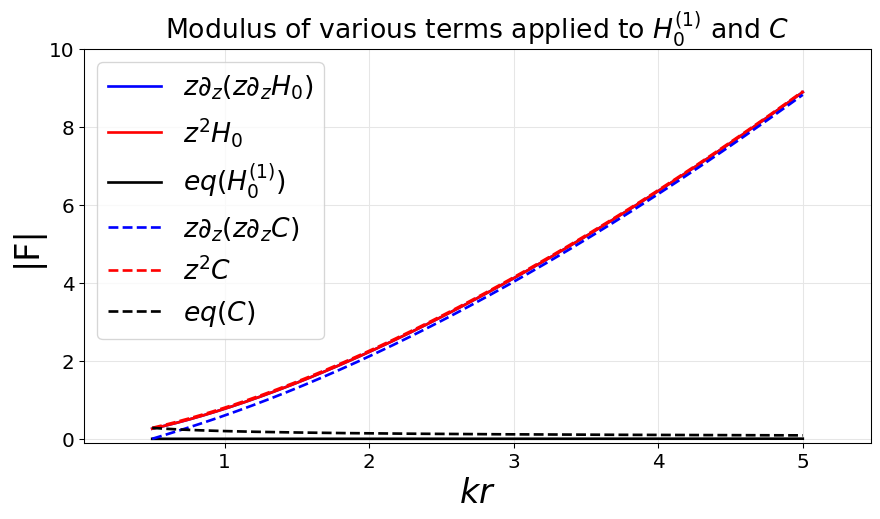

In [4]:
fz=np.abs
z=np.linspace(0.5,5,10000)
h0=hankel1(0,z)
C=np.sqrt(2/(np.pi))*np.exp(1J*(z-np.pi/4))/np.sqrt(z)

def dfdz(h0,z):
    dhdz=(h0[1:]-h0[0:-1])/(z[1:]-z[0:-1])
    return np.hstack([dhdz,dhdz[-1]])
d2h=z*dfdz(z*dfdz(h0,z),z)
d2C=z*dfdz(z*dfdz(C,z),z)

z=z[:-2]
lhs_h0=d2h[:-2]
rhs_h0=-z**2*h0[:-2]
eq_h0=lhs_h0-rhs_h0

# dfdz2C=np.sqrt(2/(np.pi))*np.exp(1J*(z-np.pi/4))*(-np.sqrt(z)+1/4*z**(-3/2))
lhs_C=d2C[:-2]
rhs_C=-z**2*C[:-2]
eq_C=lhs_C-rhs_C

tle=r'Modulus of various terms applied to $H_0^{(1)}$ and $C$ '
plts=[
    [z,fz(lhs_h0) ,'b'  ,'$z\partial_z(z\partial_z H_0)$'],
    [z,fz(rhs_h0) ,'r'  ,'$z^2H_0$'],
    [z,fz(eq_h0)  ,'k'  ,r'$eq(H_0^{(1)})$'],
    [z,fz(lhs_C ) ,'b--','$z\partial_z(z\partial_z C)$'],
    [z,fz(rhs_C)  ,'r--','$z^2C$'],
    [z,fz(eq_C)   ,'k--',r'$eq(C)$'],
]

dsp.stddisp(plts,labs=['$kr$','|F|'],lw=2,title=tle,xylims=['y',-0.1,10],figsize=figsize);


### Born approximation

Born series consists in building solutions in presence of the potential using Green's functions:

\begin{equation}
    \Psi(\mathbf r) = \Psi_0(\mathbf r) + \frac{k_0^2}{E}\int V(\mathbf r_i)H_0^{(1)}(\mathbf r-\mathbf r_i)\Psi(\mathbf r_i)d\mathbf r_i
\end{equation}

The first Born approximation assumes that in setting $\Psi=\Psi_0=Ce^{jk_0z}$ inside the integral ($C$ is the electron density normalization constant expressed in $A^{-2}$ in 2D).
In the far field, assuming the circular wave is a reasonable approximation to $H_0^{(1)}$, the first Born approximation of the wave function can be written as : 

\begin{equation}
    \Psi = Ce^{jk_0z} + C\frac{e^{jk_0r}}{\sqrt{r}}f(\theta)
\end{equation}

Using and $k_0^2/E=4\pi\frac{\sigma}{\lambda}$ and $k=2\pi/\lambda$, the scattering amplitude $f(\theta)$ expressed in ($A^{-1/2}$) are obtained as : 
\begin{equation}
    f(\mathbf q) = \frac{4\sigma}{\sqrt{\lambda}}\int \tilde V(\mathbf r)e^{2j\pi\mathbf q\cdot\mathbf r}d\mathbf r
\end{equation}
and $\mathbf q=1/2\pi(\mathbf k-\mathbf k_0)$, $q=2\sin(\theta/2)/\lambda$ and $\tilde V$ is the electrostatic potential in $kV$.

### Cross section 

The radial probability current is $J_r=C\frac{\hbar k}{m}\frac{1}{r}|f(\theta)|^2$. Noting that $J_0=C\frac{\hbar k}{m}$ is the incident flux of particles, i.e. number of electrons per second per unit length.

The number of particles detected per unit time in a detector located at distance r with an angular coverage $d\theta$ is $dn=J_rrd\theta =J_0|f(\theta)|^2d\theta$. 

The differential cross section has the same simple expression as in 3D $\sigma(\theta) = |f(\theta)|^2$.


And the total cross section : 

\begin{eqnarray}
    \sigma &=& \int_{-\pi}^{\pi} |f(\theta)|^2d\theta \\
\end{eqnarray}


## Application 
### Potential and form factor
The 2D potential :
\begin{equation}
    V(r)=exp^{-\left(\frac{r}{A_Z}\right)^2}
\end{equation}

where $A_Z$ depends on the atom type.

The corresponding form factor is  :

\begin{eqnarray}
    f(\theta)
        &=& \frac{4\sigma}{\sqrt{\lambda}}\int V(\mathbf r)e^{2j\pi \mathbf q\cdot\mathbf r}d\mathbf r\\
        &=& \frac{4\sigma}{\sqrt\lambda}\sqrt{\pi}A_Z e^{-\pi A_Z^2q^2}\\        
\end{eqnarray}

where $\sigma$ is the interaction parameter and $q=2\sin(\theta/2)/\lambda$.


/home/tarik/Documents/git/mygit/utilities/utils/displayStandards.py:749: UserWarning: Matplotlib is currently using GTK3Agg, which is a non-GUI backend, so cannot show the figure.
  if 'p' in opt : ax.figure.show()


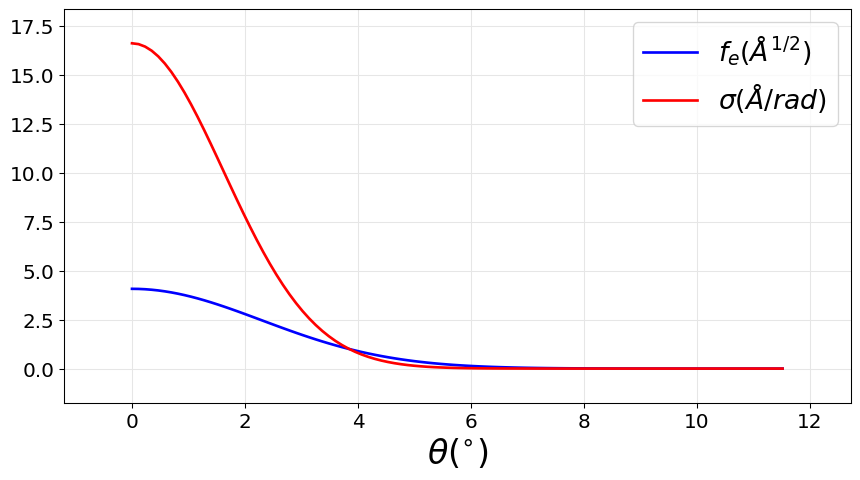

In [26]:
keV=200
eps=0.5
Za=1
Az=pg.Ai[Za]

lam=cst.keV2lam(keV)
sigma=cst.keV2sigma(keV)

q  = np.linspace(0,8,100)
fe = 4*sigma*np.sqrt(np.pi/lam)*Az*np.exp(-np.pi*Az**2*q**2)*eps

theta=2*np.arcsin(q*lam/2)
sig=fe**2
thetas=np.rad2deg(theta)
plts=[
    [thetas,fe ,'b','$f_e(\AA^{1/2})$'],
    [thetas,sig,'r','$\sigma(\AA/rad)$'],
]
dsp.stddisp(plts,labs=[r'$\theta(^{\circ})$',''],lw=2,**kwargs);



In [27]:
t=(theta[1:]+theta[0:-1])/2
dt=theta[1:]-theta[0:-1]
sig_total=2*np.sum((sig[1:]+sig[0:-1])/2*np.sin(t)*dt)
print('sig_total = %.3f A' %sig_total)

sig_total = 0.027 A


## Linear array

In [28]:
ax,bz = 1,4
pattern = np.array([[1,1,Za]])
ndeg = 2**11 #transverse sampling of the potential 
nzx = 32*bz  #sampling of the potential along propagation direction 


def V_rect(Xv,X0,Za):
    V=np.zeros(Xv.shape[0])
    V[(np.abs(Xv[:,0]-X0[0])<=0.5) & (np.abs(Xv[:,1]-X0[1])<=0.5)]=1
    return V 

def apply_padding(p1,npad,nx,nz,name='pad',show_V='TV',iZv=10,**kwargs):
    x0,z0 = np.linspace(-npad*ax,(nx+npad)*ax,ndeg),np.linspace(0,bz,nzx)
    x,z = np.meshgrid(x0,z0)
    Xv = np.stack([x.flatten(),z.flatten()]).T
    V = pg.fv
    #V = V_rect
    f = np.sum(np.array([V(Xv,X0,int(Za)) for X0,Za in zip(p1.Xa,p1.fa)]),axis=0)
    f = np.reshape(f,(nzx,ndeg))
    pattern = [x0,z0,f]

    mp0 = ms.Multi2D(pattern,ax,bz,keV=keV,
            Nx=1,dz=bz,nz=nz,s_opts='qx',
            iZs=1,iZv=iZv,eps=eps)
    
    if 'T' in show_V:        
        mp0.Tz_show(iSz=slice(0,None,1),Vopt='VT',lw=2,figsize=(10,5))#,name=figpath+name+'Tz.svg',**kwargs)
    if 'V' in show_V:
        mp0.V_show(xylims=[0,bz,0,2],figsize=(6,6))
    return mp0

		 2D multislice simulation 
Slice thickness and number of slices per cell
     lattice param z=4.00A, dz=4.00A, nzs=1
i=0   ,islice=0  I=1.0000, Iq=1.0000 iz=0, z=4.0 A
i=100 ,islice=0  I=1.0000, Iq=1.0000 iz=100, z=404.0 A
i=200 ,islice=0  I=1.0000, Iq=1.0000 iz=200, z=804.0 A
i=300 ,islice=0  I=1.0000, Iq=1.0000 iz=300, z=1204.0 A
i=400 ,islice=0  I=1.0000, Iq=1.0000 iz=400, z=1604.0 A
i=500 ,islice=0  I=1.0000, Iq=1.0000 iz=500, z=2004.0 A
i=600 ,islice=0  I=1.0000, Iq=1.0000 iz=600, z=2404.0 A
i=700 ,islice=0  I=1.0000, Iq=1.0000 iz=700, z=2804.0 A
i=800 ,islice=0  I=1.0000, Iq=1.0000 iz=800, z=3204.0 A
i=900 ,islice=0  I=1.0000, Iq=1.0000 iz=900, z=3604.0 A
i=1000,islice=0  I=1.0000, Iq=1.0000 iz=1000, z=4004.0 A


/home/tarik/Documents/git/mygit/utilities/utils/displayStandards.py:749: UserWarning: Matplotlib is currently using GTK3Agg, which is a non-GUI backend, so cannot show the figure.
  if 'p' in opt : ax.figure.show()


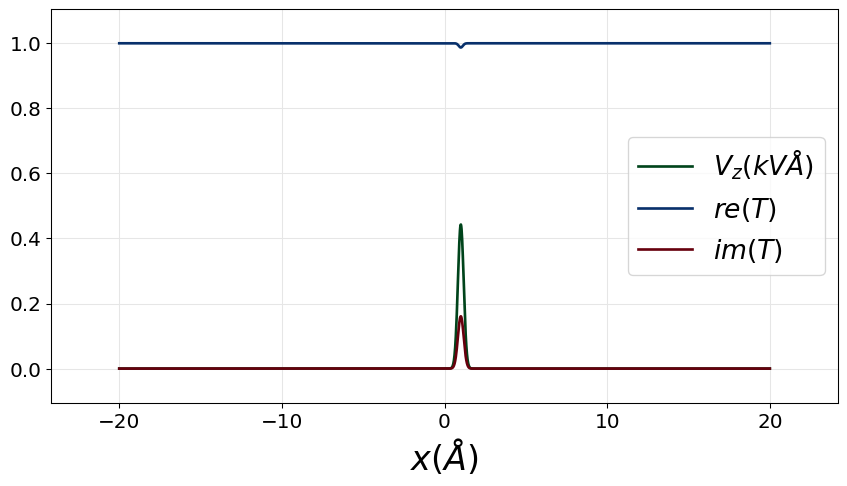

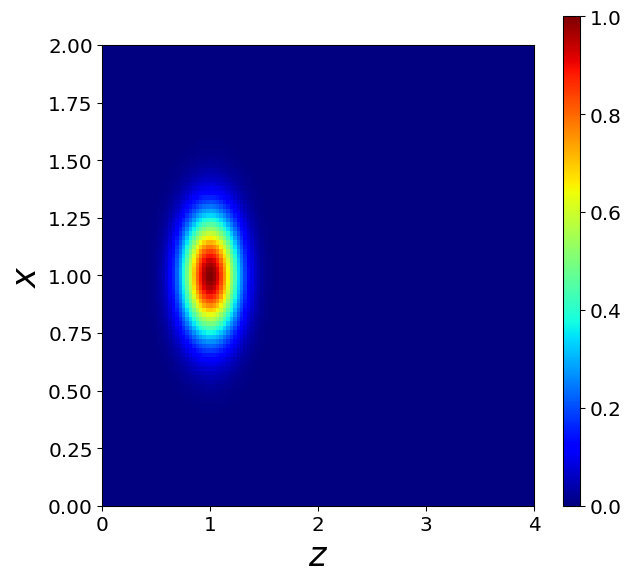

In [29]:
nz = 1001 #number of slices to simulate 
p1d = pg.Wallpaper(pp_type='p1',a=ax,b=bz,angle=90,pattern=pattern,ndeg=0,nh=1,nk=1)
mp0 = apply_padding(p1d,npad=20,nx=0,nz=nz,iZv=100,name='padnx4',show_V='TV',opt='p')

(<Figure size 960x1080 with 2 Axes>,
 <AxesSubplot:xlabel='$x(\\AA)$', ylabel='$z(\\AA)$'>)

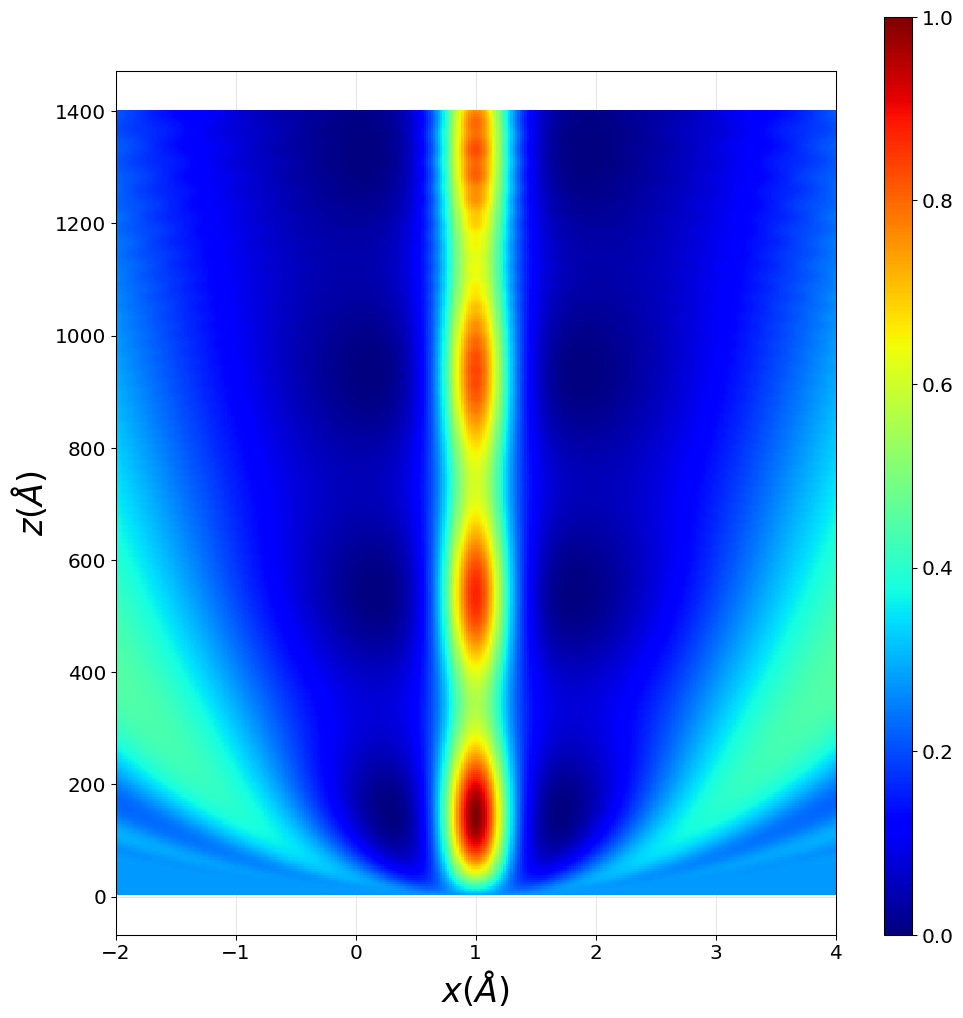

In [36]:
mp0.Xxz_show(iZs=np.arange(350),xylims=['x',-2,4],s_opt=False,imOpt='c',axPos='V')

/home/tarik/Documents/git/mygit/utilities/utils/displayStandards.py:749: UserWarning: Matplotlib is currently using GTK3Agg, which is a non-GUI backend, so cannot show the figure.
  if 'p' in opt : ax.figure.show()


(<Figure size 960x1080 with 2 Axes>,
 <AxesSubplot:xlabel='$x(\\AA)$', ylabel='$|\\Psi(x)|^2$'>)

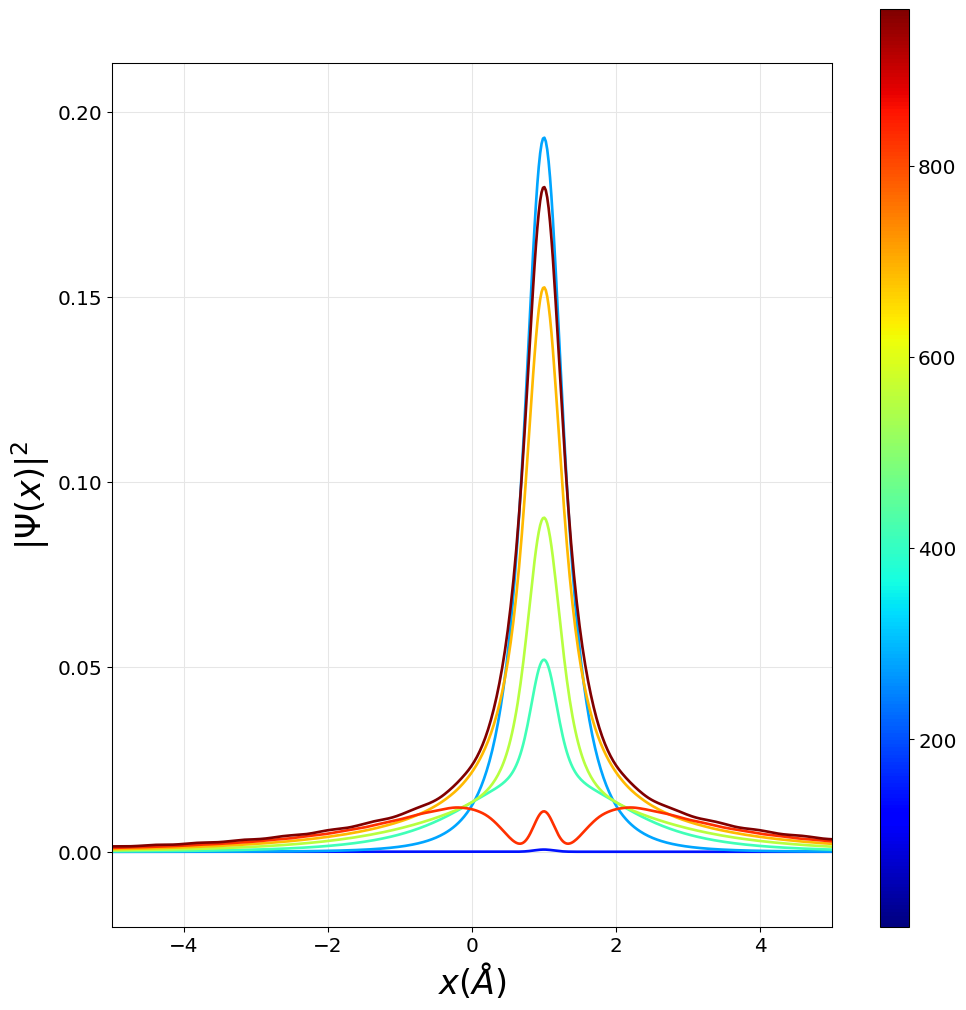

In [31]:
# mp0.Qz_show(iZs=[1,100,350,480],lw=2,opts='n',xylims=['x',-3,3])#,name=figpath+name+'Qz.svg',**kwargs)
# psi0=1/np.sqrt(np.sum(np.abs(np.ones(mp0.x.shape))**2)*mp0.dx)
# f_opt=lambda Px:np.abs(Px-psi0)**2
mp0.Xz_show(iZs=np.arange(0,251,40),s_opt=True  ,lw=2,xylims=['x',-5,5])
# mp0.Xz_show(iZs=[50,100,500],s_opt=False ,lw=2,xylims=['x',-5,5])



/home/tarik/Documents/git/mygit/utilities/utils/displayStandards.py:749: UserWarning: Matplotlib is currently using GTK3Agg, which is a non-GUI backend, so cannot show the figure.
  if 'p' in opt : ax.figure.show()


(<Figure size 960x1080 with 2 Axes>,
 <AxesSubplot:xlabel='$q(\\AA^{-1})$', ylabel='$|\\Psi(q)|^2$'>)

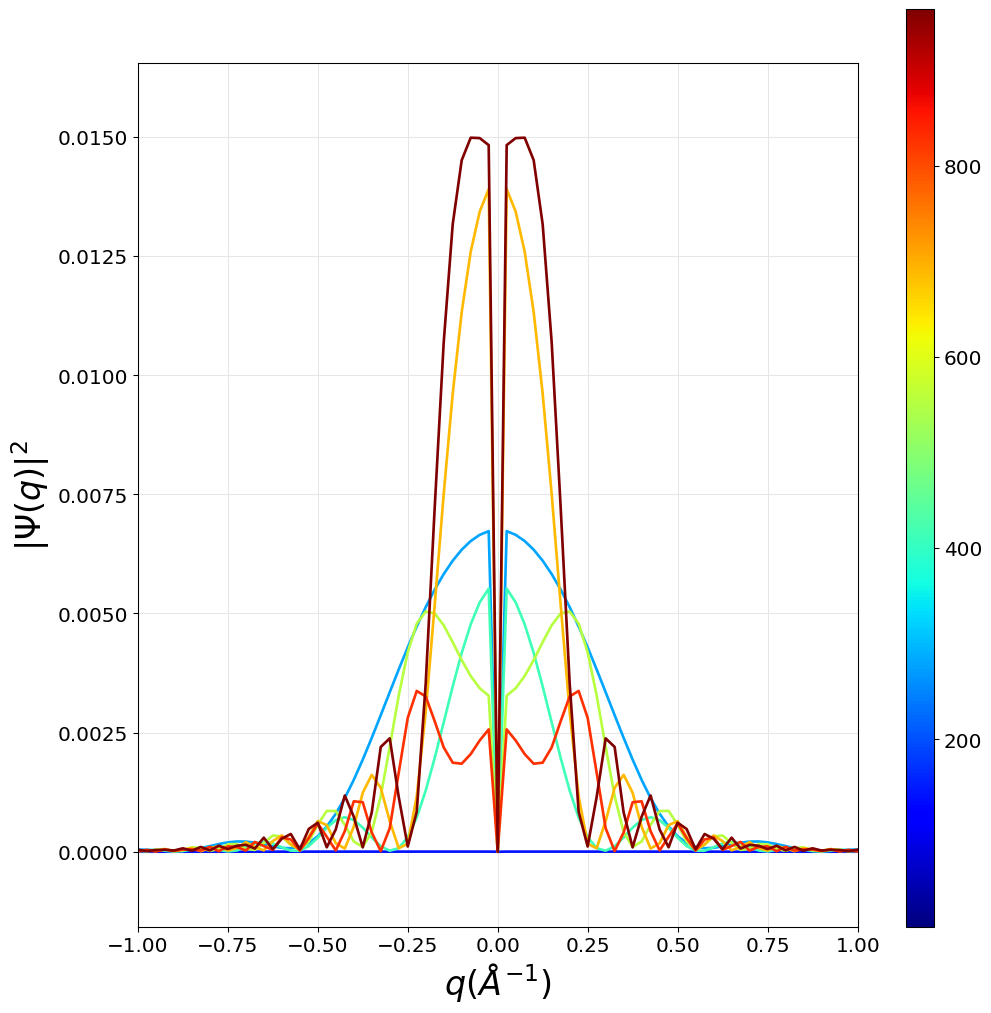

In [37]:
mp0.Qz_show(iZs=np.arange(0,251,40),lw=2,opts='',xylims=['x',-1,1])#,name=figpath+name+'Qz.svg',**kwargs)

/home/tarik/Documents/git/mygit/utilities/utils/displayStandards.py:749: UserWarning: Matplotlib is currently using GTK3Agg, which is a non-GUI backend, so cannot show the figure.
  if 'p' in opt : ax.figure.show()


(<Figure size 960x1080 with 1 Axes>, <AxesSubplot:>)

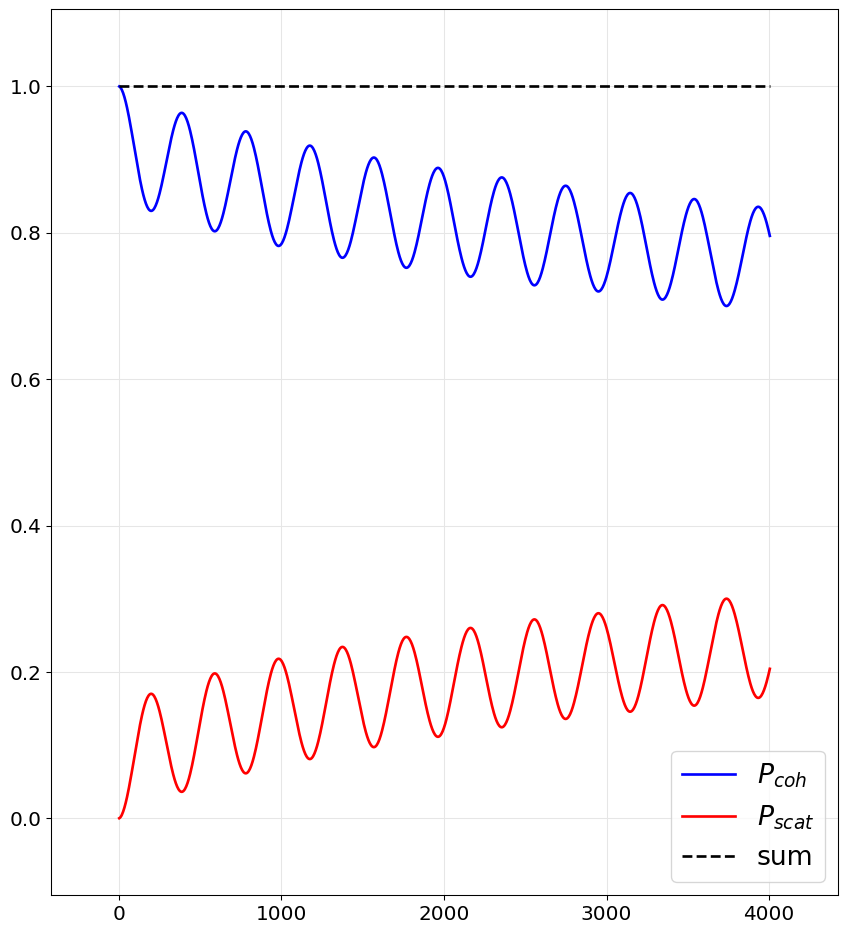

In [38]:
iBs=np.arange(0,10,1)
# iBs=[0,10]
# mp0.Bz_show(iBs=iBs,tol=1e-2,cmap='jet',lw=2)#,name=figpath+name+'Bz.svg',**kwargs)
Ib=mp0.getB(iBs='Oa',tol=0,v=0)
sumB=np.sum(Ib[:,1:],axis=1)
plts=[
    [mp0.z,Ib[:,0],'b','$P_{coh}$'],
    [mp0.z,sumB,'r','$P_{scat}$'],
    [mp0.z,sumB+Ib[:,0],'k--','sum']
]
dsp.stddisp(plts,lw=2)